# 5주차 수업 내용에 대한 과제

실제 데이터 세트에 대한 머신러닝 전체 프로세스 확인

## 데이터 입수 및 필터링

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install -U seaborn
!pip install -U scikit-learn==0.23.2
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import tensorflow as tf

%matplotlib inline

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)
Requirement already up-to-date: scikit-learn==0.23.2 in /usr/local/lib/python3.6/dist-packages (0.23.2)


UCI 머신러닝 저장소의 AUTO-MPG 데이터로 진행

- [공식 저장소](https://archive.ics.uci.edu/ml/datasets/Auto+MPG)
- [텐서플로우 튜토리얼](https://www.tensorflow.org/tutorials/keras/regression)

In [ ]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.shape

(398, 8)

In [ ]:
dataset['Cylinders'].value_counts()

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64

결측치 확인

### Q1: 결측치 행 제거

In [ ]:
# 코딩
dataset = dataset.dropna(axis=0)

In [ ]:
dataset['Cylinders'].value_counts()

4    199
8    103
6     83
3      4
5      3
Name: Cylinders, dtype: int64

### Q2: Cylinders 가 3 또는 5인 행 제거

In [ ]:
# 코딩
indexNames = dataset[ (dataset['Cylinders'] == 3) | (dataset['Cylinders'] == 5) ].index
dataset.drop(indexNames , inplace=True)

In [ ]:
dataset['Cylinders'].value_counts()

4    199
8    103
6     83
Name: Cylinders, dtype: int64

인덱스 초기화

In [ ]:
dataset = dataset.reset_index(drop=True)

### Q3: DataFrame 메서도 hist로 대략 통계 확인

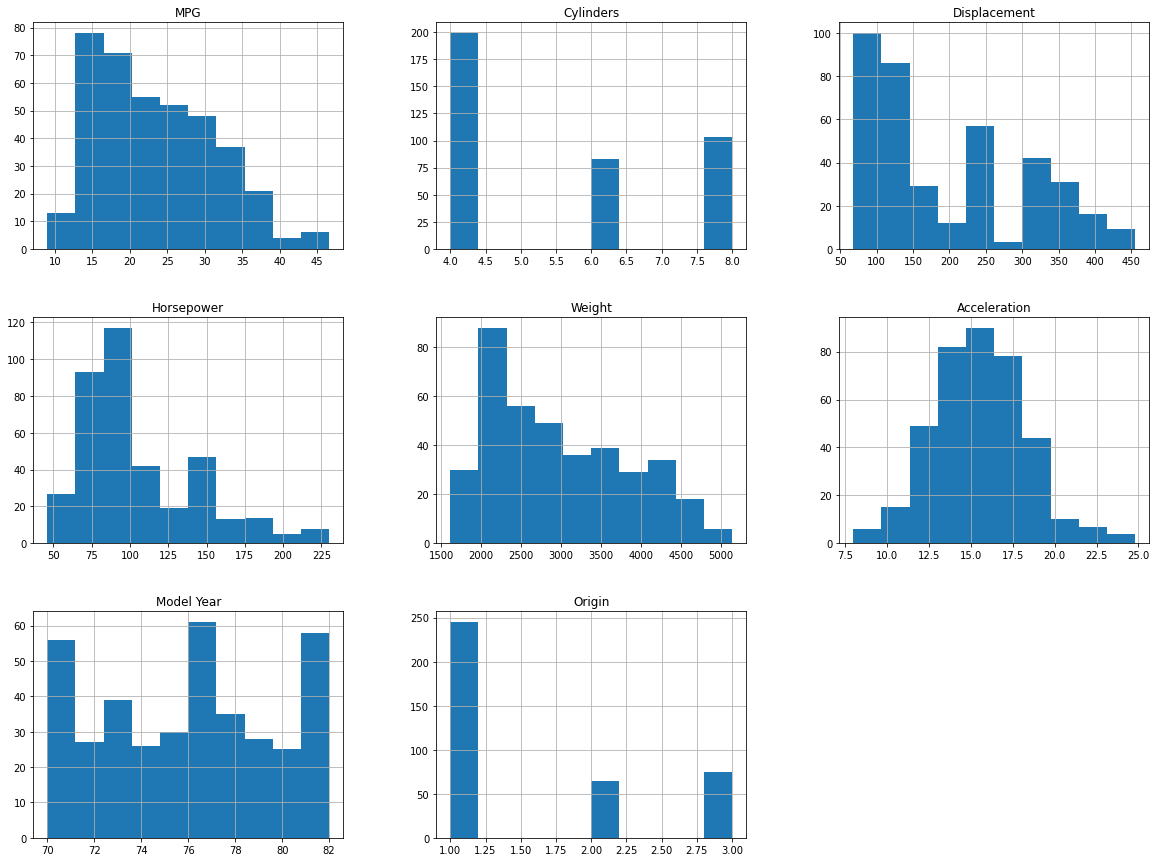

In [ ]:
# 코딩
dataset.hist(bins=10, figsize=(20,15))
plt.show()

## 학습 세트와 테스트 세트 분리



### Q4: ``Origin`` 열에 대해 계층적 샘플링 실시

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 이하 코딩
# 분할된 결과는 strat_train_set (학습 세트), strat_test_set (테스트 세트) 로 생성하자.

for train_index, test_index in split.split(dataset, dataset["Origin"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

원본 dataset과 strat_test_set에서 Origin의 분포 정도 확인

In [ ]:
dataset['Origin'].value_counts() / len(dataset)

1    0.636364
3    0.194805
2    0.168831
Name: Origin, dtype: float64

In [ ]:
strat_test_set['Origin'].value_counts() / len(strat_test_set)

1    0.636364
3    0.194805
2    0.168831
Name: Origin, dtype: float64

seaborn 시각화를 이용하여 관찰

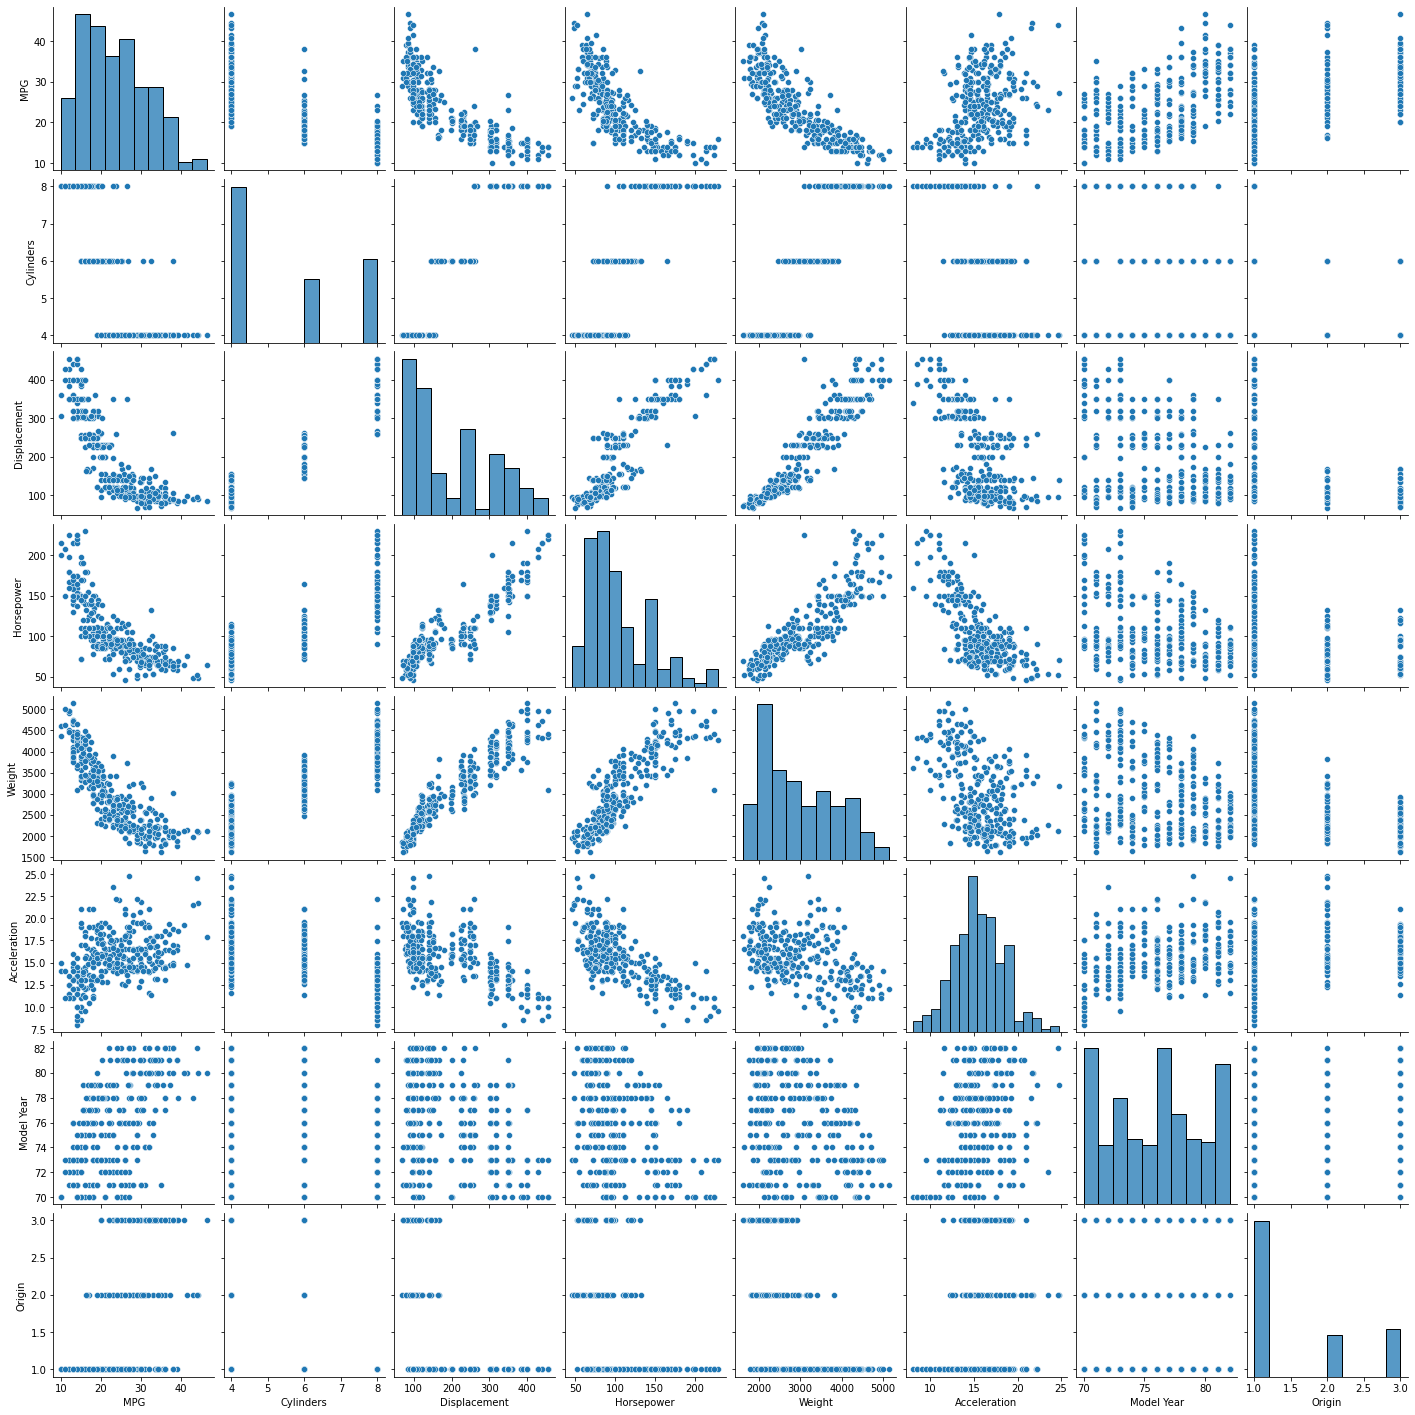

In [ ]:
sns.pairplot(strat_train_set)

### Q5 (옵션): seaborn 시각화를 통한 인사이트 탐구

MPG(연비)는 Displacement(변위)와 Horsepower(마력), Weight(무게)와 음의 상관관계를 보이며 Acceleraion과 양의 상관관계를 보이는 것을 간단히 확인할 수 있다.

## 데이터파이프라인 작성

특성과 타겟으로 분리

In [ ]:
train_X = strat_train_set.copy()
train_y = train_X.pop('MPG')

In [ ]:
train_X

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
273,4,98.0,68.0,2135.0,16.6,78,3
64,8,351.0,153.0,4129.0,13.0,72,1
134,8,318.0,150.0,4457.0,13.5,74,1
139,4,97.0,78.0,2300.0,14.5,74,2
332,4,79.0,58.0,1755.0,16.9,81,3
...,...,...,...,...,...,...,...
196,6,250.0,78.0,3574.0,21.0,76,1
14,4,113.0,95.0,2372.0,15.0,70,3
210,8,302.0,130.0,3870.0,15.0,76,1
66,8,429.0,208.0,4633.0,11.0,72,1


### Q6: 수치 특성 열은 StandardScaler, 카테고리 특성 열은 OneHotEncoder로 변환하는 전체 파이프라인 작성

```Python
num_attribs = ["Displacement", "Horsepower", "Weight", "Acceleration", "Model Year"]
cat_attribs = ["Cylinders", "Origin"]
```

으로 구분할 것

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

num_attribs = ["Displacement", "Horsepower", "Weight", "Acceleration", "Model Year"]
cat_attribs = ["Cylinders", "Origin"]

# 코딩 영역
# 변환된 결과는 train_tr_X로 받자

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

train_tr_X = full_pipeline.fit_transform(train_X)

In [ ]:
train_tr_X.shape

(308, 11)

## 모델 학습 및 튜닝

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_tr_X, train_y)

LinearRegression()

In [ ]:
from sklearn.metrics import mean_squared_error

train_predicted = lin_reg.predict(train_tr_X)
lin_mse = mean_squared_error(train_y, train_predicted)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.9330741451638214

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

### Q7: 선형 회귀를 K-겹 교차 검증으로 학습 평가 하기

- cv = 10으로 하여 진행해보자

In [ ]:
from sklearn.model_selection import cross_val_score

# 코딩 영역
# 교차 검증 결과는 lin_scores로 받자

lin_scores = cross_val_score(lin_reg, train_tr_X, train_y,
                         scoring="neg_mean_squared_error", cv=10)

In [ ]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [2.27325138 3.3317407  2.50215367 4.18045031 3.69647931 2.75948977
 2.77260558 2.85744974 2.87328082 2.81790003]
평균: 3.006480129857716
표준 편차: 0.5425205031996182


### Q8: 그리드 탐색을 통해 RandomForestRegressor 하이퍼 파라미터 탐색

```Python
n_estimators를 [30, 50, 100, 150]
max_features를 [2,3,4,5,6,7]
```
에 대해 조사해보자. (랜덤시드에 설정에 따라 전체적인 결과가 현재 코랩의 아웃풋과 약간씩 다를 수 있음)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 50, 100, 150], 'max_features': [2, 3, 4, 5, 6, 7]},
  ]

# 코딩
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_tr_X, train_y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 3, 4, 5, 6, 7],
                          'n_estimators': [30, 50, 100, 150]}],
             return_train_score=True, scoring='neg_mean_squared_error')

베스트 파라미터, 베스트 모델 등을 관찰해보자

In [ ]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=50, random_state=42)

In [ ]:
np.sqrt(-pd.DataFrame(grid_search.cv_results_)['mean_test_score'])

0     2.812316
1     2.755705
2     2.781604
3     2.761997
4     2.784950
5     2.758687
6     2.772666
7     2.764735
8     2.618994
9     2.603266
10    2.615874
11    2.633875
12    2.762573
13    2.714960
14    2.656204
15    2.647586
16    2.662995
17    2.642772
18    2.635800
19    2.614361
20    2.620064
21    2.637312
22    2.623298
23    2.614500
Name: mean_test_score, dtype: float64

## 테스트 세트에 대해 테스트

In [ ]:
test_X = strat_test_set.copy()
test_y = test_X.pop('MPG')

### Q9: 테스트 세트에 대한 RMSE를 구하고 출력해보자

In [ ]:
# 코딩의 영역

final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(test_X)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

2.8829217052222487

### Q10 (옵션): 테스트 세트에 대해 더 나은 성적을 얻을 수 있는지 노력해보자

- RandomForestRegressor 의 하이퍼파라미터 더욱 탐색
- sklearn.svm 의 SVR을 이용
- 등

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(train_tr_X, train_y)
final_predictions = svm_reg.predict(train_tr_X)
svm_mse = mean_squared_error(train_y, final_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

3.0633512410019317

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [30, 50, 80, 100, 120, 150, 180, 200], 'max_features': [2, 3, 4, 5, 6, 7, 8]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_tr_X, train_y)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

test_X = strat_test_set.copy()
test_y = test_X.pop('MPG')

final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(test_X)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(test_y, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

{'max_features': 5, 'n_estimators': 100}
RandomForestRegressor(max_features=5, random_state=42)
2.844805932257557


sklearn.svm 의 SVR을 이용을 해보았지만 더 나은 결과를 얻을 수 없었다.

RandomForestRegressor 의 하이퍼파라미터 더욱 탐색을 하였지만 예상 외의 결과였다. grid_search.grid_search.best_params_의 결과로 'max_features': 5, 'n_estimators': 100 이 grid_search.best_estimator_의 결과로 max_features=5이 나왔다. final_rmse의 값은 **2.844805932257557** 였다. 전의 grid_search.best_estimator_를 이용한 결과값인 **2.8829217052222487 보다 약 0.04가 줄어든 것** 을 확인할 수 있다.

하지만 max_features': 5, 'n_estimators': 100 는 전에도 충분히 나올 수 있는 값인데 불구하고 지금에서야 더 오차가 줄어드는 것이 의문이다. 단지 cv=5를 줄여서 그런 것인걸까?

## Q 11 (옵션): 5주차 내용에 대한 소감을 적어보자

Q10을 수행하면서 더 나은 성적을 얻을 수 있는 방법을 찾는 것은 생각보다 더욱 어려웠습니다. 또한, 왜 저런 결과값이 나오는 지도 아직 잘 이해가 가지 않는 상황입니다. StandardScaler와 OneHotEncoder 등 데이터파이프라인에 대한 이해도가 조금 떨어져 데이터파이프라인을 작성하는 데에 많은 애를 먹었습니다. 이번 5주차 내용은 좀 더 철저한 복습이 요구되는 내용인 것 같습니다.

## 참고

[Tensorflow 기본 튜토리얼](https://www.tensorflow.org/tutorials/keras/regression) 을 코랩으로 열어 따라가 보자.
